In [1]:
%reload_ext autoreload
%autoreload 2

import os
from astroquery.gaia import Gaia
import astropy
from astropy.coordinates import SkyCoord
import astropy.units as u
from sklearn.cluster import DBSCAN
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import utils as ut
import plot_utils as pu
import utils
from ezpadova import parsec

In [2]:
cluster_dic = ut.cluster_dic
cluster_names = ['Hyades', '47 Tucanae']

for cluster_name in cluster_names:
    cluster = cluster_dic[cluster_name]
    adql_query = ut.cluster_query(cluster)
    job = Gaia.launch_job_async(adql_query)
    data = job.get_results()
    data = ut.preprocess_data(data)
    cluster_dic[cluster_name]['data'] = data
    print(cluster_name+':', len(data), 'stars')

INFO: Query finished. [astroquery.utils.tap.core]
Hyades: 132 stars
INFO: Query finished. [astroquery.utils.tap.core]
47 Tucanae: 5757 stars


C:\Users\Pere\AppData\Local\Temp\ipykernel_27360\1616993412.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=color, label=labels[k], s=4*fs)
C:\Users\Pere\AppData\Local\Temp\ipykernel_27360\1616993412.py:53: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter([], [], c=color, label=labels[k], s=4*fs)


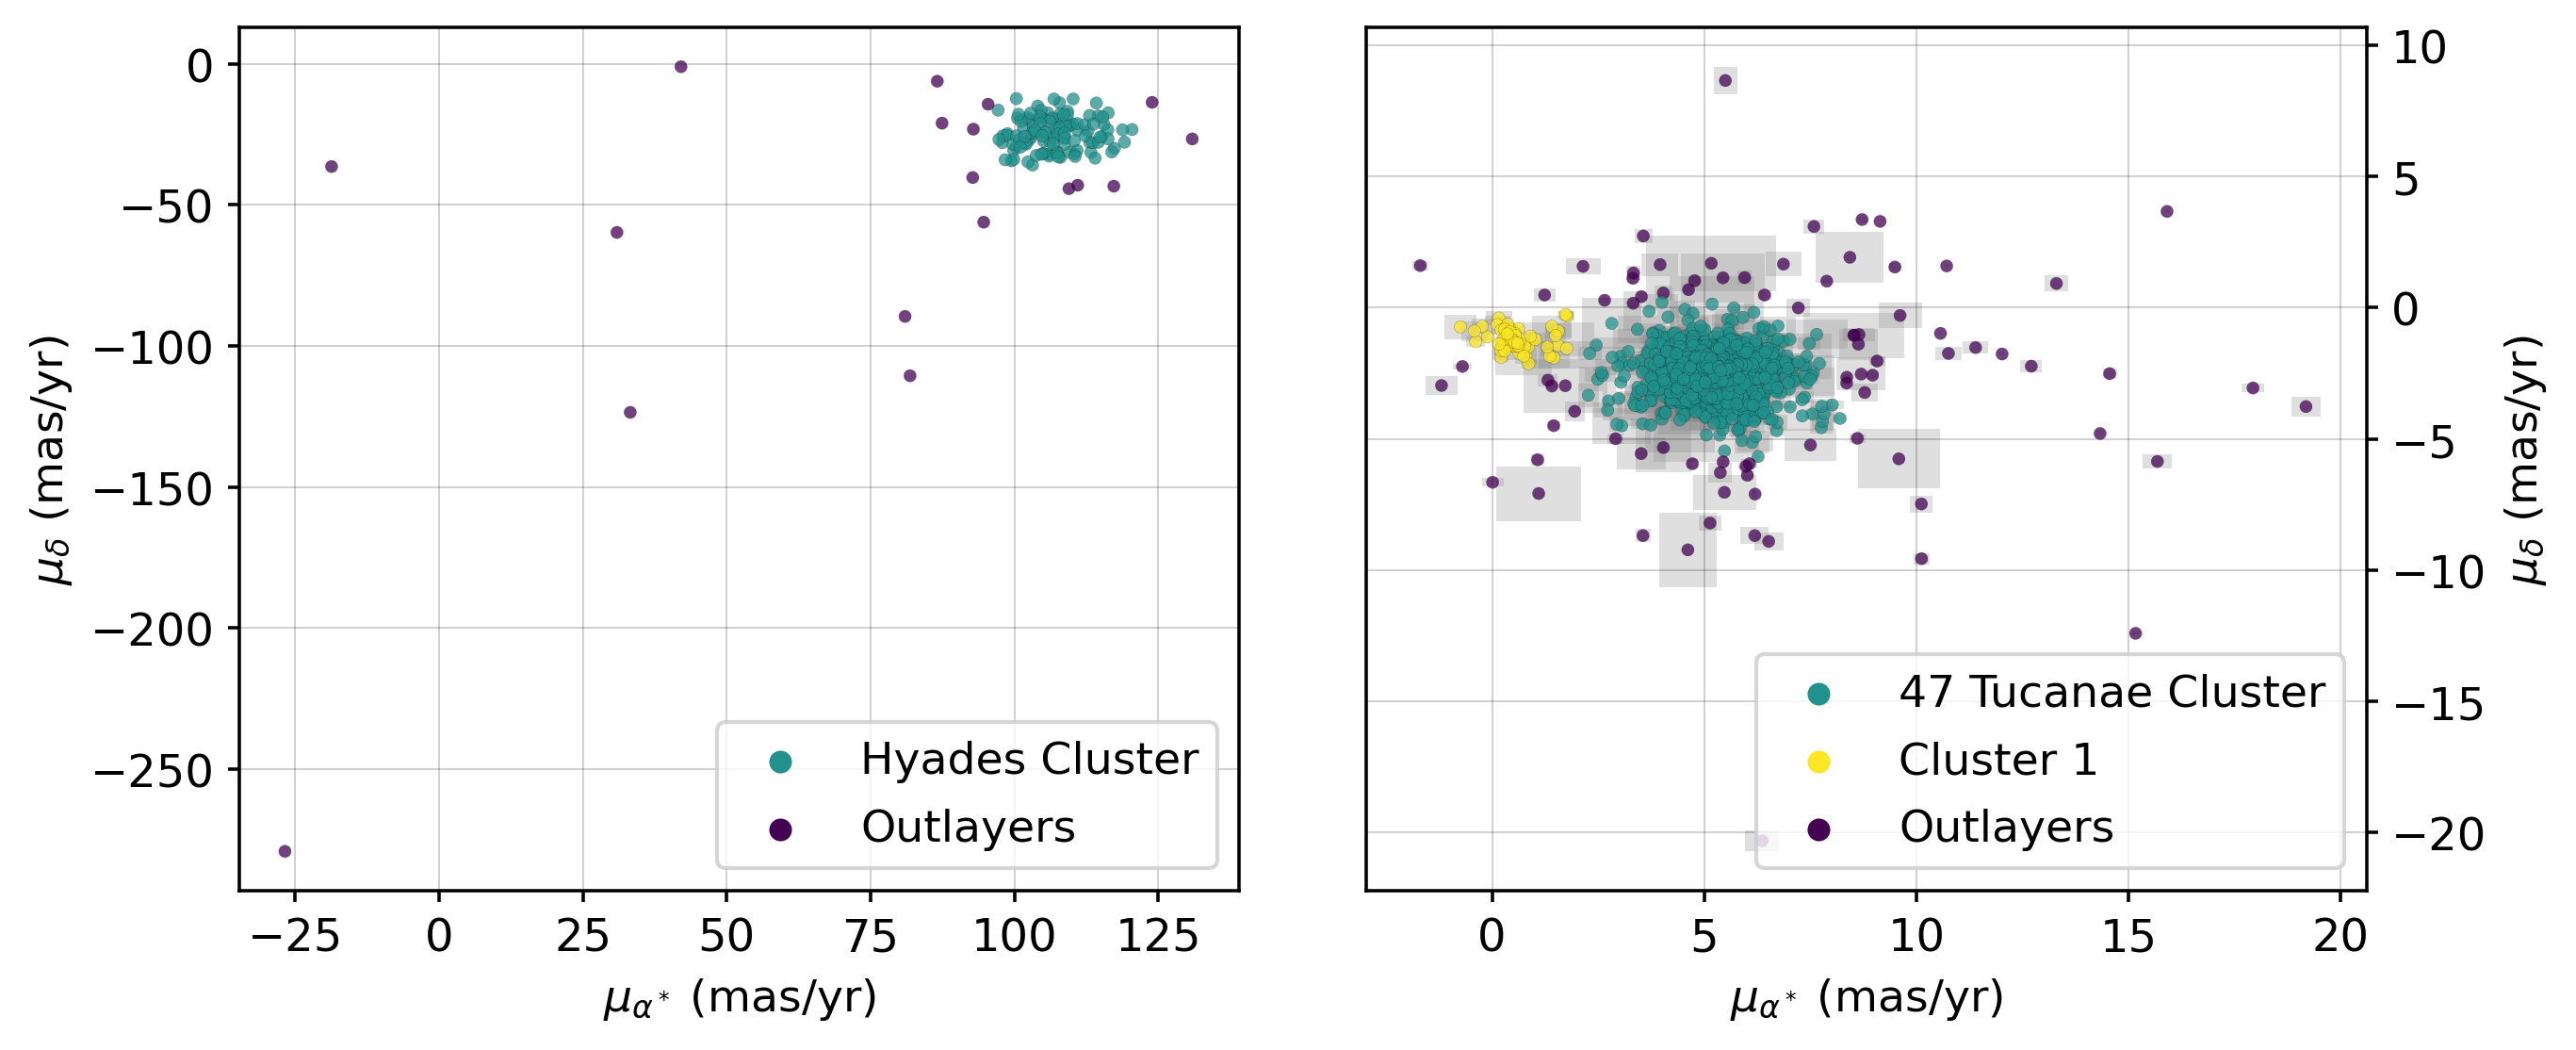

In [3]:
size, rat = 1080, 2.5
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

cmap = mpl.colormaps['viridis']
subclusters_list = []

eps_ = [5, 0.75]
for i, cluster_name in enumerate(cluster_names):
    cluster = cluster_dic[cluster_name]
    data = cluster['data']
    x, y = data['pmra'], data['pmdec']
    x_err, y_err = data['pmra_error'], data['pmdec_error']
    pmot_arr = np.array([x, y]).T

    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps_[i], min_samples=10) 
    clusters = dbscan.fit_predict(pmot_arr)
    subclusters_list.append(clusters)


    M = len(list(set(list(clusters))))
    cmap_crop = ListedColormap(cmap(np.linspace(0, 1 if M == 3 else 0.5, 256)))

    ax = axs[0][i]

    ax.scatter(pmot_arr[:, 0], pmot_arr[:, 1], c=clusters, cmap=cmap_crop, s=1.75*fs, zorder=4, 
    linewidths=0.01*fs, edgecolor='k', alpha=0.75)

    # Adding rectangles for each point to represent the errors
    for xi, yi, x_err_i, y_err_i in zip(x, y, x_err, y_err):
        rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.25)
        ax.add_patch(rect)

    ax.set_xlabel(r'$\mu_{\alpha^*}$ (mas/yr)', fontsize=2*fs)
    ax.set_ylabel(r'$\mu_{\delta}$ (mas/yr)', fontsize=2*fs)

    colors = np.linspace(0, 256, M)  # Replace with the actual cluster labels
    labels = [cluster_name + ' Cluster']  # Replace with the desired cluster labels
    for k in range(M-2):
        labels.append(f'Cluster {k+1}')
    labels.append('Outlayers')

    colors = [cmap(a) for a in np.linspace(0, 1 if M == 3 else 0.5, M)]
    if i==1:
        a = colors[-2] 
        colors[-2] = colors[-1]
        colors[-1] = a

    for k, color in enumerate(colors[::-1]):
        ax.scatter([], [], c=color, label=labels[k], s=4*fs)

    ax.legend(scatterpoints=1, frameon=True, 
            labelspacing=0.1*fs, 
            loc='lower right',
            fontsize=2*fs)


# set axs[0][1] yaxis to the right
axs[0][1].yaxis.tick_right()
axs[0][1].yaxis.set_label_position("right")

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'cluster_proper_motion_distributions.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

In [4]:
# Cleaning the Data

desired_subcluster = 0 
for i, cluster_name in enumerate(cluster_names):
    cluster = cluster_dic[cluster_name]
    data = cluster['data']
    mask = subclusters_list[i] == desired_subcluster
    data_f1 = data[mask]
    print(cluster_name+' stars:')
    print('Original: ', len(data))
    print('Subcluster: ', len(data_f1))
    perr = 2
    data_f1 = data_f1[data_f1['parallax_over_error'] > perr]
    print('Parallax error > ', perr, ': ', len(data_f1))
    data_f1 = data_f1[data_f1['phot_bp_mean_flux_over_error'] > perr]
    print('BP error > ', perr, ': ', len(data_f1))
    data_f1 = data_f1[data_f1['phot_rp_mean_flux_over_error'] > perr]
    print('RP error > ', perr, ': ', len(data_f1))
    data_f1 = data_f1[data_f1['astrometric_excess_noise'] < 1]
    print('Excess noise < 1: ', len(data_f1))

    cluster_dic[cluster_name]['data_filt'] = data_f1

Hyades stars:
Original:  132
Subcluster:  114
Parallax error >  2 :  114
BP error >  2 :  114
RP error >  2 :  114
Excess noise < 1:  98
47 Tucanae stars:
Original:  5757
Subcluster:  5611
Parallax error >  2 :  3232
BP error >  2 :  3232
RP error >  2 :  3232
Excess noise < 1:  3225


C:\Users\Pere\AppData\Local\Temp\ipykernel_27360\1724708922.py:13: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data_fl['bp_rp_mag'], data_fl['g_abs'],


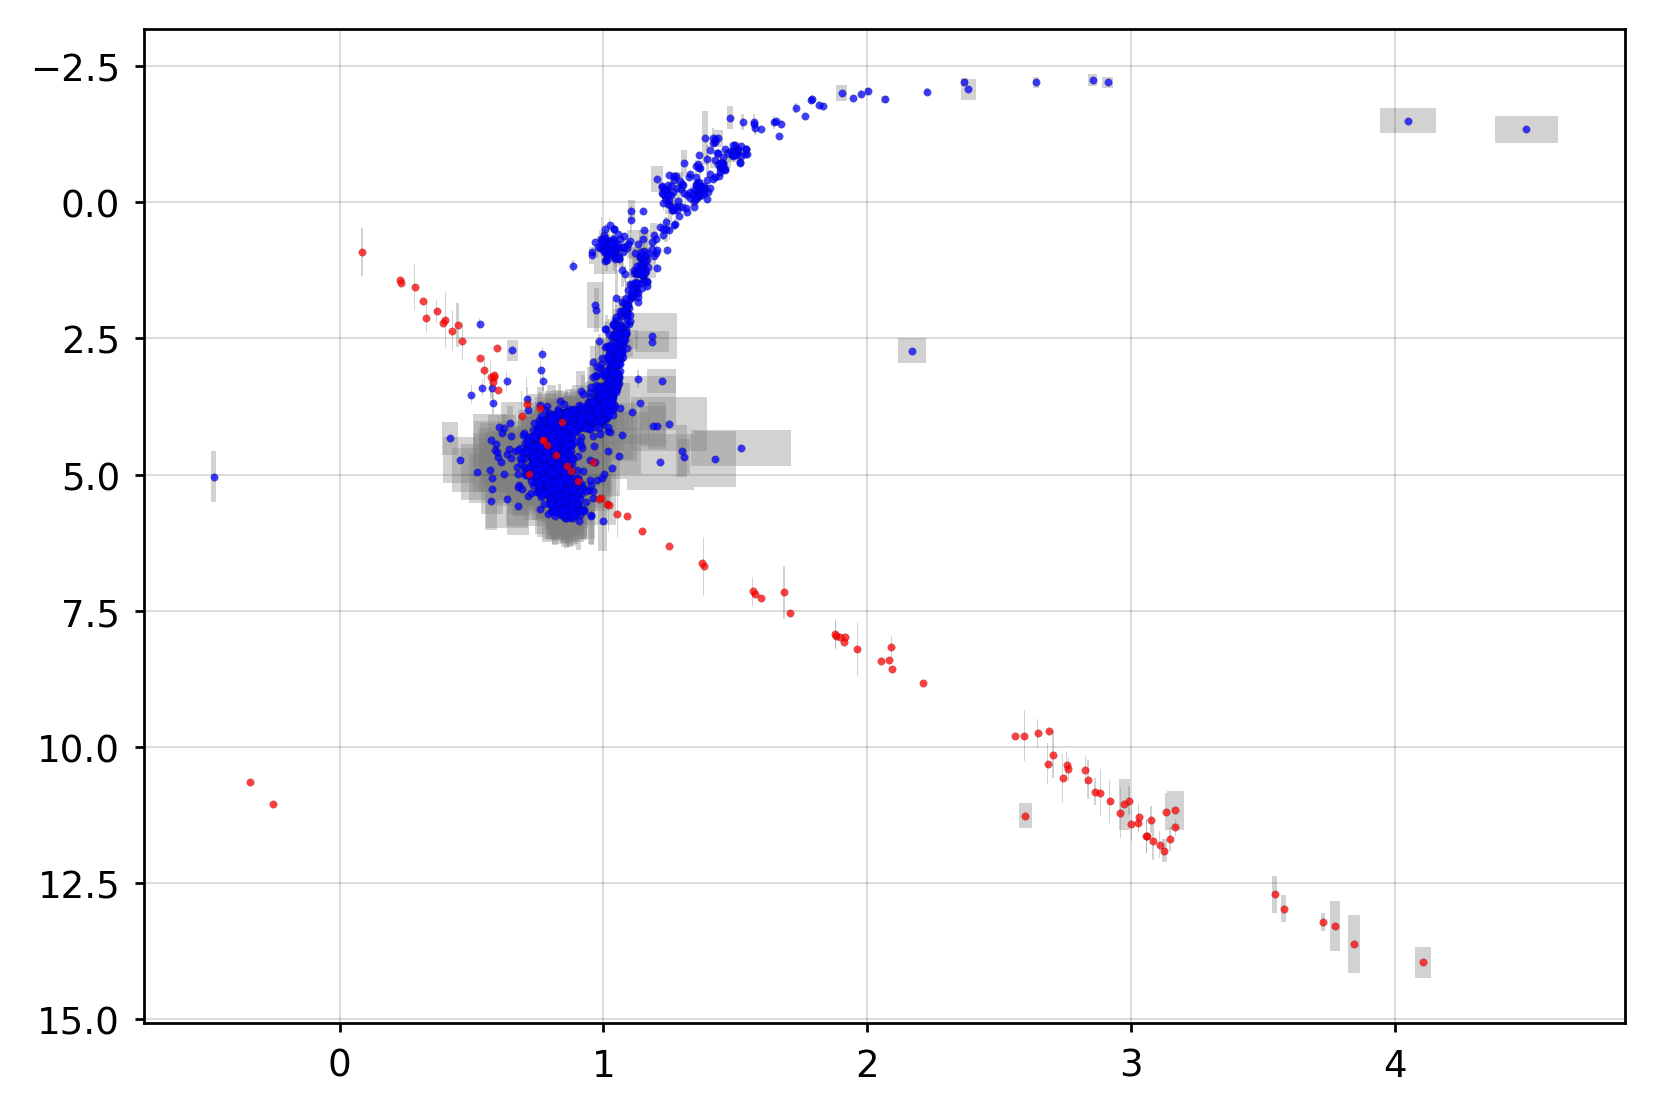

In [5]:
size, rat = 1080, 1.5
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

ax = axs[0][0]
cs = ['r', 'b']
for i, cluster_name in enumerate(cluster_names):
    cluster = cluster_dic[cluster_name]
    data_fl = cluster['data_filt']

    ax.scatter(data_fl['bp_rp_mag'], data_fl['g_abs'], 
               s=0.75*fs, c=cs[i], cmap=cmap, alpha=0.75, zorder=4-i,
               linewidths=0.01*fs, edgecolor='k')

    # Adding rectangles for each point to represent the errors
    for xi, yi, x_err_i, y_err_i in zip(data_fl['bp_rp_mag'], data_fl['g_abs'], 
                                        data_fl['bp_rp_mag_error'], data_f1['g_abs_error']):
        rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
        ax.add_patch(rect)


ax.invert_yaxis()

Hyades filtered stars: 98
Post filtering: 92
47 Tucanae filtered stars: 3225
Post filtering: 2227


C:\Users\Pere\AppData\Local\Temp\ipykernel_27360\2831634512.py:59: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(data_fl['bp_rp'], data_fl['phot_bp_rp_excess_factor'],


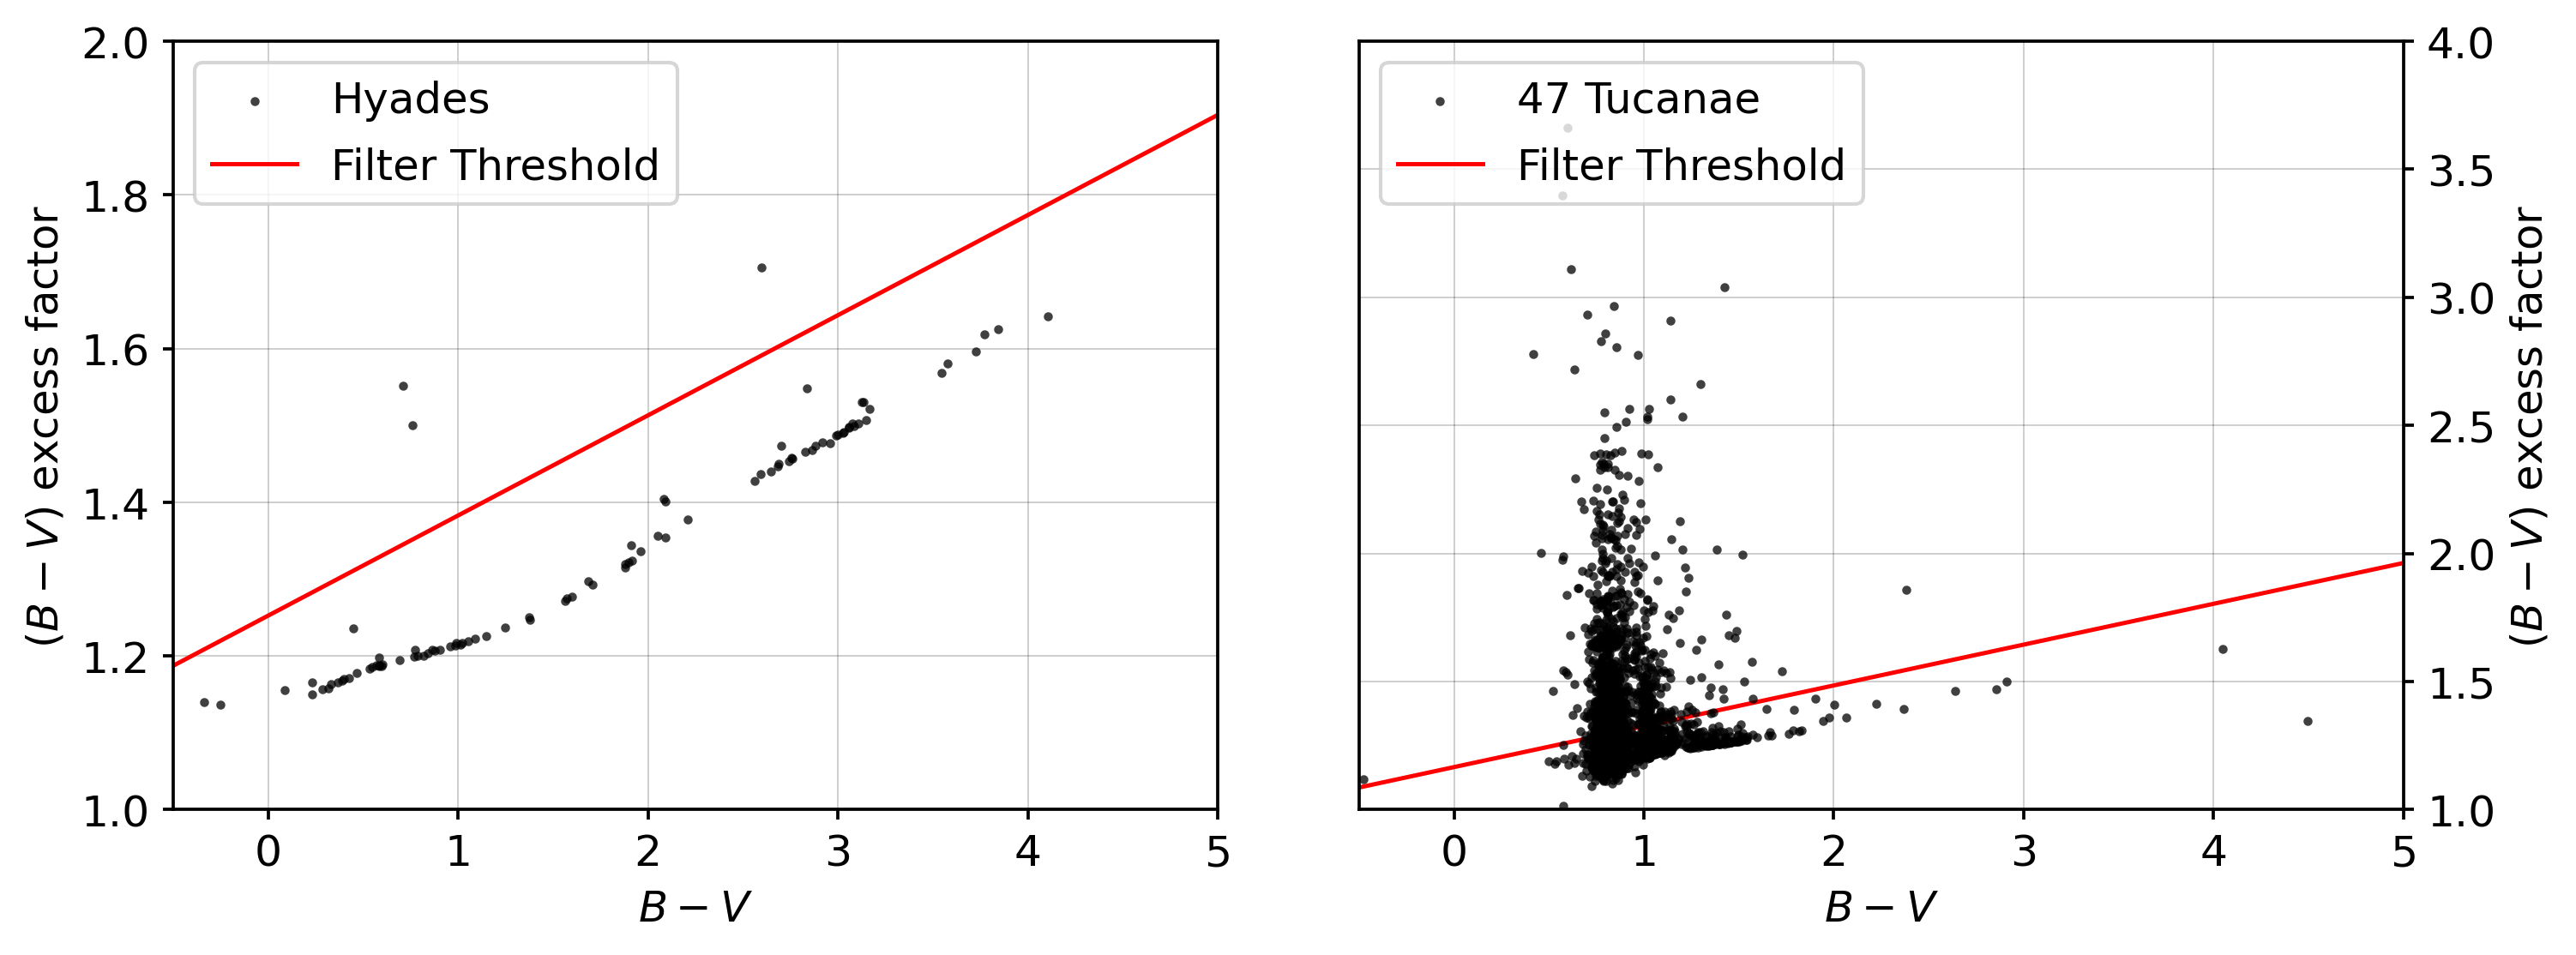

In [6]:
size, rat = 1080, 2.75
fig_w, fig_h = size*rat, size
subplots = (1, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

tols = [0.15, 0.15]
for i, cluster_name in enumerate(cluster_names):
    cluster = cluster_dic[cluster_name]
    data_fl = cluster['data_filt']

    min_lim = np.min(data_fl['bp_rp'])
    #min_lim = 0.5
    max_lim = np.max(data_fl['bp_rp'])
    #max_lim = 3

    # for each interval in bp_rp_arr, find tha min value of phot_bp_rp_excess_factor
    bp_rp_arr = np.linspace(min_lim, max_lim, 10)
    # Initialize an empty list to store the minimum values
    min_values = []
    for k in range(len(bp_rp_arr) - 1):
        lower_bound = bp_rp_arr[k]
        upper_bound = bp_rp_arr[k + 1]
        
        # Filter the data based on the current interval
        mask = (data_fl['bp_rp'] >= lower_bound) & (data_fl['bp_rp'] < upper_bound)
        filtered_data = data_fl['phot_bp_rp_excess_factor'][mask]
        
        # Find the minimum value in the filtered data
        if len(filtered_data) > 0:  # Check if there are any values in the current interval
            min_value = np.min(filtered_data)
            min_values.append(min_value)
        else:
            min_values.append(np.nan)  # Assign NaN if no values are found in the interval

    min_values = np.array(min_values)

    valid_mask = ~np.isnan(min_values)

    # Filter out nan values
    filtered_bp_rp = bp_rp_arr[:-1][valid_mask]
    filtered_min_values = min_values[valid_mask]

    # Perform the linear fit
    slope, intercept = np.polyfit(filtered_bp_rp[1:], filtered_min_values[1:], 1)

    tol = tols[i]

    mask = data_fl['phot_bp_rp_excess_factor'] < slope * data_fl['bp_rp'] + intercept + tol
    data_f2 = data_fl[mask]
    cluster_dic[cluster_name]['data_filt_2'] = data_f2
    

    print(cluster_name+' filtered stars:', len(data_fl))
    print('Post filtering:', len(data_f2))

    ax = axs[0][i]

    ax.scatter(data_fl['bp_rp'], data_fl['phot_bp_rp_excess_factor'], 
               s=1*fs, c='k', cmap=cmap, alpha=0.75, zorder=4-i,
               linewidths=0.01*fs, edgecolor='k', label=cluster_name)
    
    x1, x2 = -0.5, 5
    p1, p2 = [x1, intercept + slope*x1 + tol], [x2,  intercept + slope*x2 + tol]
    ax.plot([p1[0], p2[0]], [p1[1], p2[1]], color='r', linewidth=0.2*fs, label='Filter Threshold')
    # ax.plot(bp_rp_arr[:-1], min_values, color='grey', linewidth=0.2*fs)

    ax.set_xlim(-0.5,5)

    ax.set_ylabel(r'$(B-V)$ excess factor', fontsize=2*fs)
    ax.set_xlabel(r'$B-V$', fontsize=2*fs)

    # plot legend
    ax.legend(scatterpoints=1, frameon=True, 
            labelspacing=0.1*fs, 
            loc='upper left',
            fontsize=2*fs)


axs[0][0].set_ylim(1, 2)
axs[0][1].set_ylim(1, 4)

axs[0][1].yaxis.tick_right()
axs[0][1].yaxis.set_label_position("right")

Hyades
Slope: 0.68
Intercept: -0.00
Mean Extintion: 3.89e-04
Mean Reddening: 2.17e-04
p90 Extintion: 1.15e-03 (5 Stars above)
p99 Extintion: 2.43e-03 (0 Stars above)
47 Tucanae
Slope: 0.54
Intercept: 0.00
Mean Extintion: 5.96e-02
Mean Reddening: 3.20e-02
p90 Extintion: 2.40e-01 (210 Stars above)
p99 Extintion: 6.10e-01 (21 Stars above)


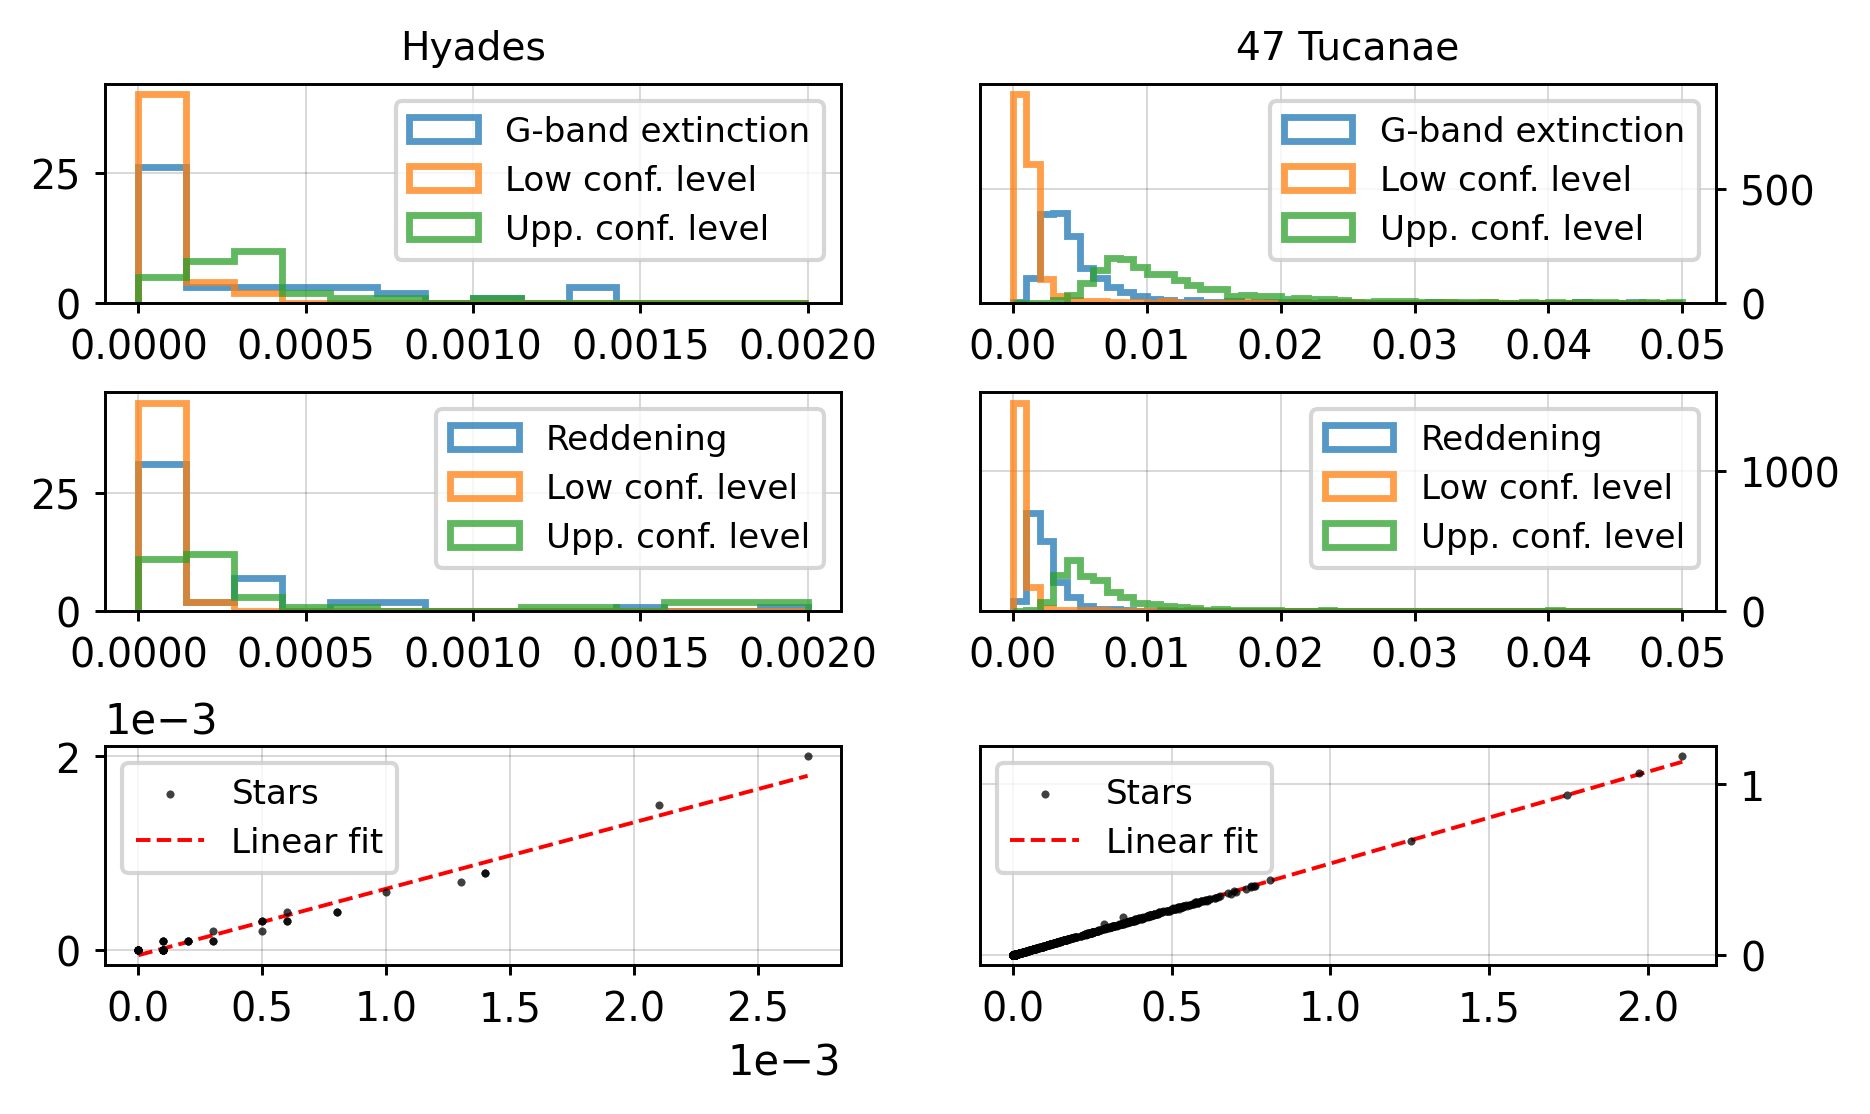

In [7]:
size, rat = 1080, 1.7
fig_w, fig_h = size*rat, size
subplots = (3, 2)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

cmap = mpl.colormaps['viridis']
subclusters_list = []

eps_ = [5, 0.75]
for i, cluster_name in enumerate(cluster_names):
    print(cluster_name)
    cluster = cluster_dic[cluster_name]
    data = cluster['data_filt_2']
    x, y = np.array(data['ag_gspphot']), np.array(data['ebpminrp_gspphot'])

    mask = ~np.isnan(x) & ~np.isnan(y)
    # Apply the masks to x and y
    x_valid = x[mask]
    y_valid = y[mask]
    slope, intercept = np.polyfit(x_valid, y_valid, 1)
    print(f'Slope: {slope:0.02f}')
    print(f'Intercept: {intercept:0.02f}')
    print(f'Mean Extintion: {np.nanmean(x):0.02e}')
    print(f'Mean Reddening: {np.nanmean(y):0.02e}')
    print(f'p90 Extintion: {np.percentile(x_valid, 90):0.02e} ({0.1*len(x_valid):0.0f} Stars above)')
    print(f'p99 Extintion: {np.percentile(x_valid, 99):0.02e} ({0.01*len(x_valid):0.0f} Stars above)')




    ax = axs[0][i]
    ax_ = axs[1][i]
    ax__ = axs[2][i]

    # make histogram fo the distributino of x
    # define the range and number of bins
    bin_range = (0, 0.002) if i==0 else (0, 0.05)
    num_bins = 14 if i==0 else 50
    # create the histogram
    # hist, bins = np.histogram(x, bins=num_bins, range=bin_range)
    # hist, bins = np.histogram(x, bins=num_bins, range=bin_range)

    # plot the histogram
    ax.hist(x, bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step',
            linewidth=0.35*fs, label='G-band extinction')
    ax.hist(data['ag_gspphot_lower'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Low conf. level')
    ax.hist(data['ag_gspphot_upper'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Upp. conf. level')

    ax_.hist(y, bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step',
             linewidth=0.35*fs, label='Reddening')
    ax_.hist(data['ebpminrp_gspphot_lower'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Low conf. level')
    ax_.hist(data['ebpminrp_gspphot_upper'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Upp. conf. level')

    ax__.scatter(x, y, c='k', s=0.75*fs, zorder=4, 
                linewidths=0.01*fs, edgecolor='k', alpha=0.75,
                label='Stars')
# plot the line with slope intercept
    x1, x2 = np.nanmin(x), np.nanmax(x)
    p1, p2 = [x1, intercept + slope*x1], [x2,  intercept + slope*x2]
    ax__.plot([p1[0], p2[0]], [p1[1], p2[1]], color='r', linewidth=0.2*fs, 
              label='Linear fit', linestyle='--')

    # plot legend
    for xa in [ax, ax_, ax__]:
        xa.legend(scatterpoints=1, frameon=True, 
                labelspacing=0.1*fs, 
                loc='upper right' if xa in [ax, ax_] else 'upper left',
                fontsize=1.75*fs)
        
    ax__.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

axs[0][0].set_title('Hyades', fontsize=2*fs)
axs[0][1].set_title('47 Tucanae', fontsize=2*fs)

# axs[2][1].set_xlim(0, 0.5)

for i in range(3):
    axs[i][1].yaxis.tick_right()
    axs[i][1].yaxis.set_label_position("right")





savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'extintion.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')



Hyades
47 Tucanae


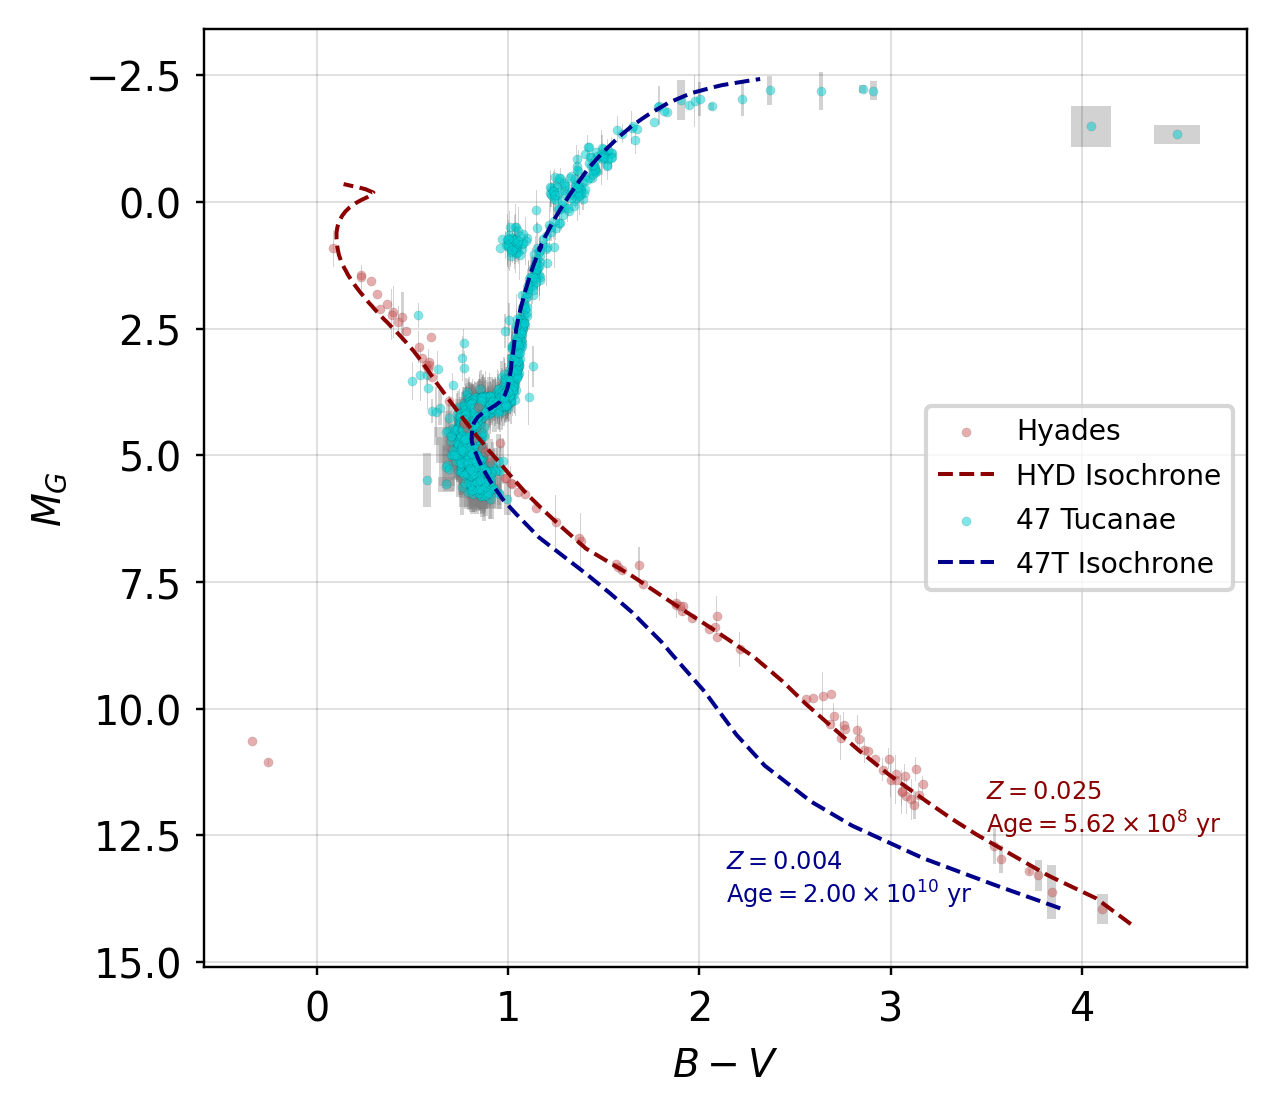

In [13]:
size, rat = 1080, 1.15
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.65, wspace=0.1)


# Alicia dice que cambie la metalicidad para ajustar


ax = axs[0][0]
cs = ['indianred', 'darkturquoise']
colors = ['darkred', 'darkblue']
for i, cluster_name in enumerate(cluster_names[:]):
    cluster = cluster_dic[cluster_name]
    data_fl = cluster['data_filt_2']

    Gmag_intrinsic = data_fl['g_abs'] - data_fl['ag_gspphot'].filled(0)
    color_intrinsic = data_fl['bp_rp_mag'] - data_fl['ebpminrp_gspphot'].filled(0)

    scatter = ax.scatter(data_fl['bp_rp_mag'], data_fl['g_abs'], 
               s=1.25*fs, c=cs[i], alpha=0.5, zorder=4-i,
               linewidths=0.01*fs, edgecolor='k',
               label=cluster_name
               )

    # ax.scatter(color_intrinsic, Gmag_intrinsic, 
    #            s=0.75*fs, c='k', alpha=0.75, zorder=4-i,
    #            linewidths=0.01*fs, edgecolor='k')

    # Adding rectangles for each point to represent the errors
    for xi, yi, x_err_i, y_err_i in zip(data_fl['bp_rp_mag'], data_fl['g_abs'], 
                                        data_fl['bp_rp_mag_error'], data_f1['g_abs_error']):
        rect = mpl.patches.Rectangle((xi - x_err_i/2, yi - y_err_i/2), x_err_i, y_err_i, facecolor='grey', alpha=0.35)
        ax.add_patch(rect)

    cluster_name_ = cluster_name.replace(' ', '_')

    path_data = f'../data/isochrone_{cluster_name_}.txt'
    df = pd.read_csv(path_data, delim_whitespace=True, comment='#')

    # give me a list of colors
    #colors = plt.cm.viridis(np.linspace(0.25, 1, len(list(set(list(df['logAge']))))))
    

    if cluster_name == 'Hyades':
        print('Hyades')
        Z_HYD = 0.025
        log_age_HYD = 8.75
        df = df[df['Zini'] == Z_HYD]
        df = df[df['logAge'] == log_age_HYD]
        
    elif cluster_name == '47 Tucanae':
        print('47 Tucanae')
        Z_47T = 0.004
        log_age_47T = 10.3
        df = df[df['Zini'] == Z_47T]
        df = df[df['logAge'] == log_age_47T]


    for l, z in enumerate(list(set(list(df['Zini'])))):
        for m, logage in enumerate(list(set(list(df['logAge'])))):
            df_ = df[(df['Zini'] == z) & (df['logAge'] == logage)]

            iso_color = np.array(df_['G_BPmag']) - np.array(df_['G_RPmag'])
            iso_lum = np.array(df_['Gmag'])
            # age = np.array(df_['Age'])

            acr = 'HYD' if cluster_name == 'Hyades' else '47T'
            flim = -490 if i==0 else -75  
            ilim = 3 if i==0 else 1
            im_iso = ax.plot(iso_color[ilim:flim], iso_lum[ilim:flim], linestyle='--',
                            color=colors[i], linewidth=0.25*fs, 
                            label=f'{acr} Isochrone',
                            alpha = 1-0.2*l,
                            zorder=4)

ax.set_xlabel(r'$B-V$', fontsize=2.45*fs)
ax.set_ylabel(r'$M_G$', fontsize=2.45*fs)



ax.legend(frameon=True,
            labelspacing=0.15*fs, 
            loc='center right',
            fontsize=1.75*fs)

ax.invert_yaxis()

age_sci = f'{(10**log_age_HYD):0.2e}'
age_sci = age_sci.replace('e', ' \\times 10^{') + '}'
age_sci = age_sci.replace('+0', '')
ax.text(0.75, 0.135, f'$Z={Z_HYD}$\nAge$={age_sci}$ yr', horizontalalignment='left', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=1.5*fs, color=colors[0])

age_sci = f'{(10**log_age_47T):0.2e}'
age_sci = age_sci.replace('e', ' \\times 10^{') + '}'
age_sci = age_sci.replace('+', '')
ax.text(0.5, 0.06, f'$Z={Z_47T}$\nAge$={age_sci}$ yr', horizontalalignment='left', verticalalignment='bottom', 
        transform=ax.transAxes, fontsize=1.5*fs, color=colors[1])

savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'HR_isochrone_fit.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

Hyades
[8.25, 8.5, 8.75, 9.0]
[0.01, 0.012, 0.014, 0.016, 0.018, 0.02, 0.022, 0.024, 0.026, 0.028, 0.03, 0.032, 0.034, 0.036, 0.038, 0.04, 0.042, 0.044, 0.046, 0.048]
47 Tucanae
[9.8, 10.0, 10.2, 10.4]
[0.001, 0.00125, 0.0015, 0.00175, 0.002, 0.00225, 0.0025, 0.00275, 0.003, 0.00325, 0.0035, 0.00375, 0.004, 0.00425, 0.0045, 0.00475]


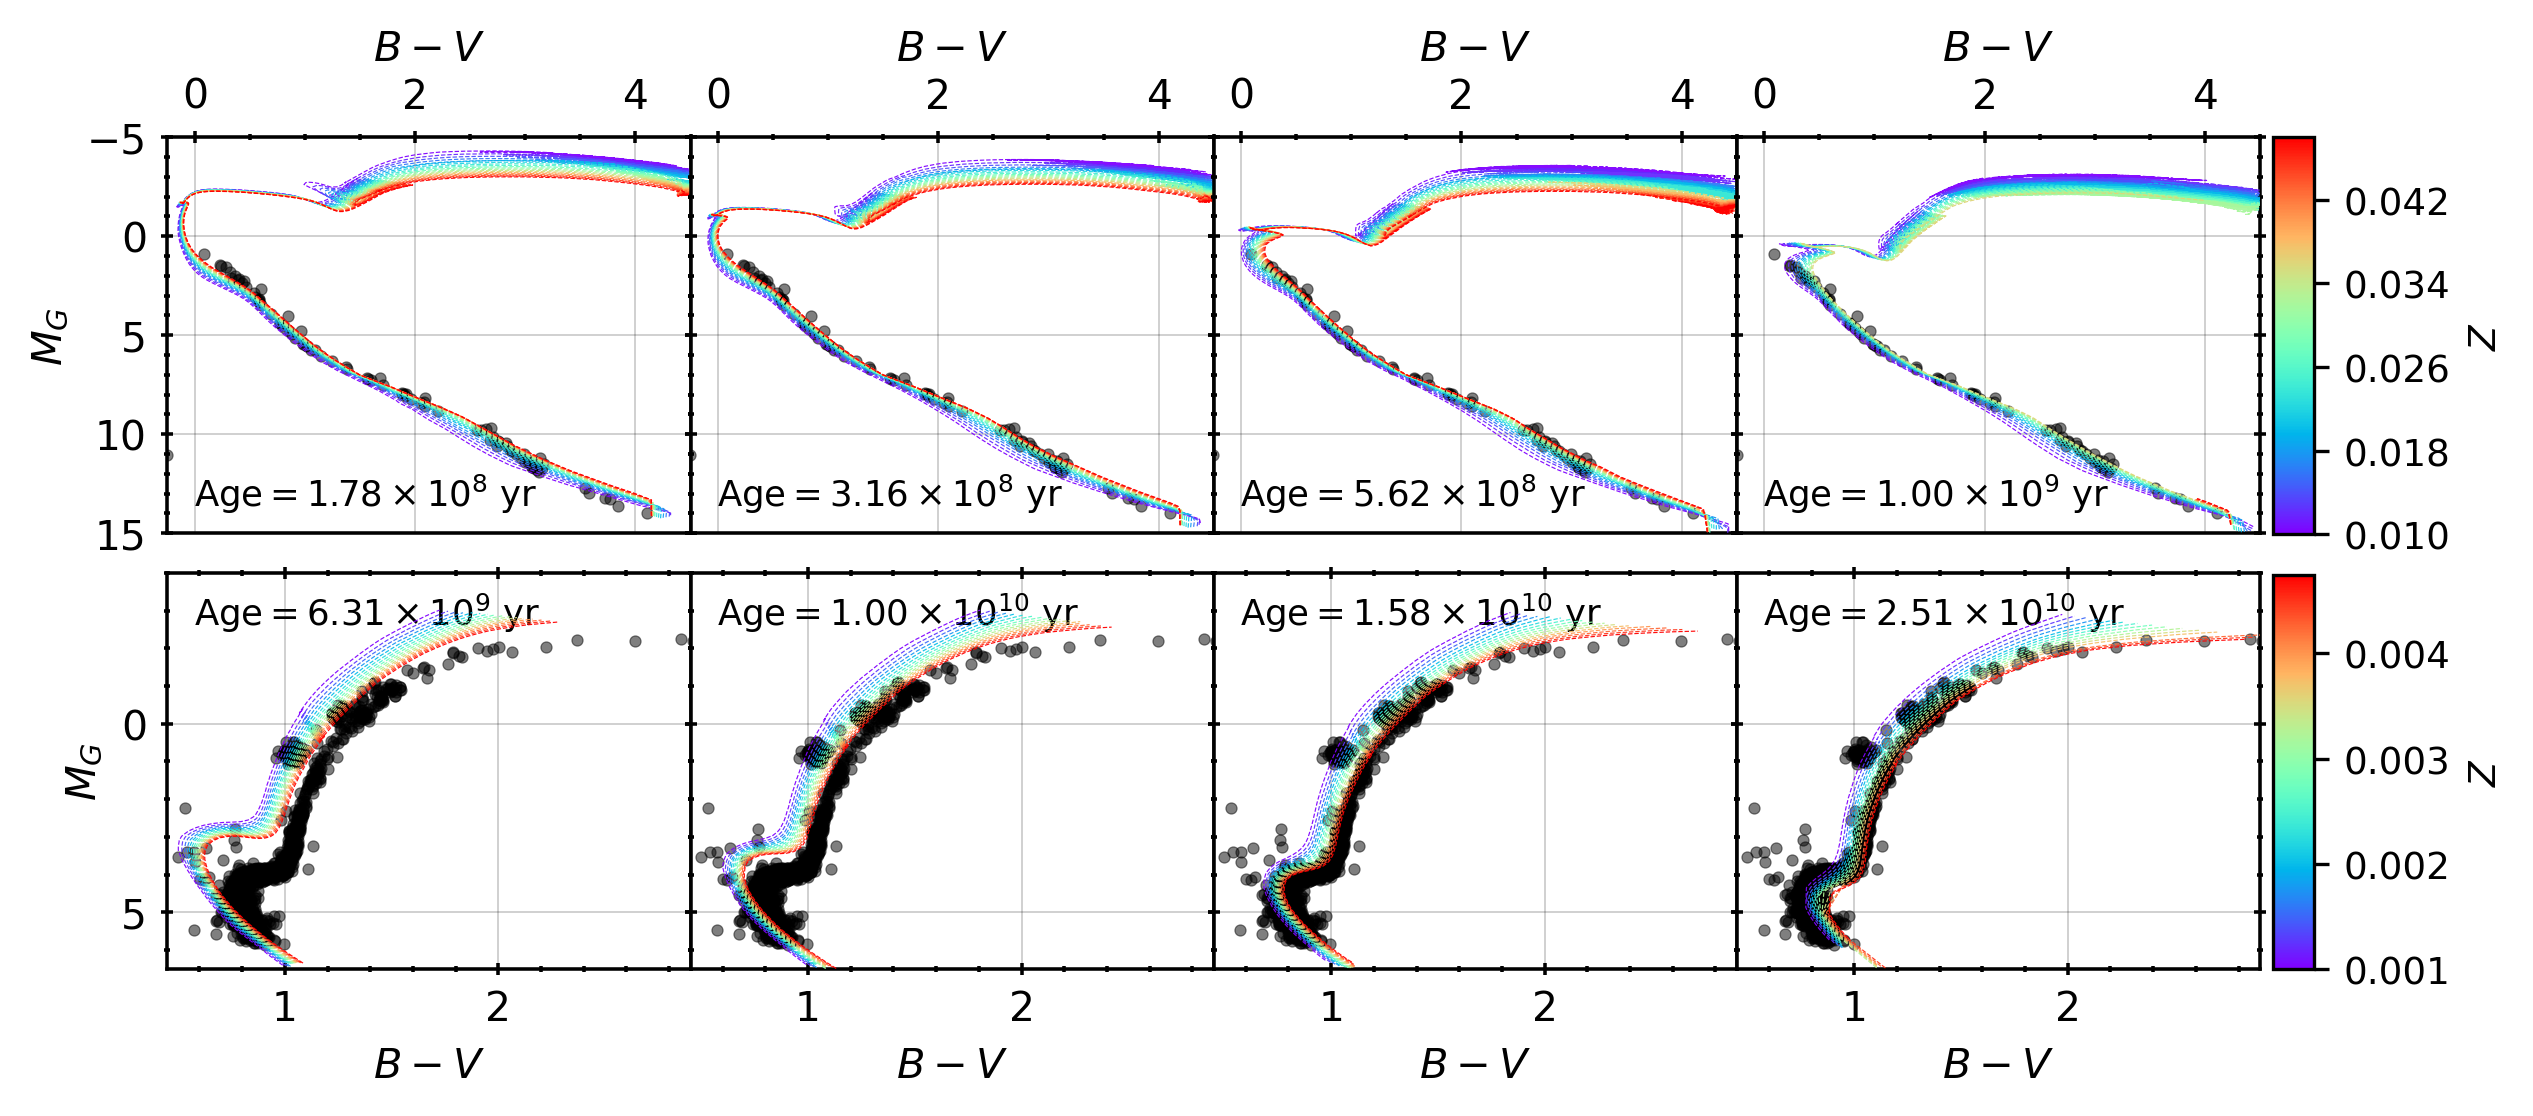

In [11]:
size, rat = 1080, 2.5
fig_w, fig_h = size*rat, size
subplots = (2, 4)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.15, 
                                   wspace=0, hspace=0.1, top_bool=True, minor=True,
                                   layout=None, tick_direction='inout')

ts=1.75
# Alicia dice que cambie la metalicidad para ajustar


ax = axs[0][0]
cs = ['r', 'cyan']
# for i, cluster_name in enumerate(cluster_names[:]):
#     cluster = cluster_dic[cluster_name]
#     data_fl = cluster['data_filt_2']
#     Gmag_intrinsic = data_fl['g_abs'] - data_fl['ag_gspphot'].filled(0)
#     color_intrinsic = data_fl['bp_rp_mag'] - data_fl['ebpminrp_gspphot'].filled(0)

for j in range(len(axs)):
    cluster_name = cluster_names[j]
    cluster = cluster_dic[cluster_name]
    data_fl = cluster['data_filt_2']
    Gmag_intrinsic = data_fl['g_abs'] - data_fl['ag_gspphot'].filled(0)
    color_intrinsic = data_fl['bp_rp_mag'] - data_fl['ebpminrp_gspphot'].filled(0)

    cluster_name_ = cluster_name.replace(' ', '_')

    path_data = f'../data/isochrone_{cluster_name_}_new.txt'
    df = pd.read_csv(path_data, delim_whitespace=True, comment='#')
    ages = list(set(list(df['logAge'])))
    ages.sort()
    metallicities = list(set(list(df['Zini'])))
    metallicities.sort()

    print(cluster_name)
    print(ages)
    print(metallicities)

    for k in range(len(axs[0])):
        ax = axs[j][k]
        im = ax.scatter(data_fl['bp_rp_mag'], data_fl['g_abs'], 
                   s=1.25*fs, alpha=0.5, zorder=5,
                   linewidths=0.05*fs, edgecolor='k',
                   label=cluster_name,
                   facecolors='k'  # set facecolors to 'none'
                  )
        
        if k != 0:
            ax.set_yticklabels([])
        else:
            ax.set_ylabel(r'$M_G$', fontsize=ts*fs)
        if j != 1:
            # set xlabels on top
            ax.xaxis.tick_top()
            ax.xaxis.set_label_position("top")
        ax.set_xlabel(r'$B-V$', fontsize=ts*fs)

        colors = plt.cm.rainbow(np.linspace(0, 1, len(metallicities)))

        for l, z in enumerate(metallicities):
            # for m, logage in enumerate()):
            df_ = df[(df['Zini'] == z) & (df['logAge'] == ages[k])]

            iso_color = np.array(df_['G_BPmag']) - np.array(df_['G_RPmag'])
            iso_lum = np.array(df_['Gmag'])

            if cluster_name == 'Hyades':
                mask1 = (iso_color > -0.25) & (iso_color < 4.5)
                mask2 = (iso_lum > -5) & (iso_lum < 15)
                mask = mask1 & mask2
            elif cluster_name == '47 Tucanae':
                mask1 = (iso_color > 0.45) & (iso_color < 3)
                mask2 = (iso_lum > -4) & (iso_lum < 6.5)
                mask = mask1 & mask2
            iso_color = iso_color[mask]
            iso_lum = iso_lum[mask]
            iso_color_diff = np.diff(iso_color)
            iso_lum_diff = np.diff(iso_lum)
            dif = np.sqrt(iso_color_diff**2 + iso_lum_diff**2)
            turn_idxs = list(np.where(dif > 1)[0])

            if len(turn_idxs) > 0:
                 turn_idx = turn_idxs[0]
            else:
                turn_idx = -1


            acr = 'HYD' if cluster_name == 'Hyades' else '47T'
            flim = -1 if j==0 else -1 
            ilim = 3 if j==0 else 20
            im_iso = ax.plot(iso_color[:turn_idx], iso_lum[:turn_idx], linestyle='--',
                            color=colors[l], linewidth=0.05*fs, 
                            label=f'$Z={z}$',
                            alpha = 0.95,
                            zorder=5)
            
        if k == 2:
            # make a discrete colorbar with the variable colors
            sm = plt.cm.ScalarMappable(cmap=mpl.cm.rainbow, norm=plt.Normalize(vmin=np.min(metallicities), vmax=np.max(metallicities)))
            sm.set_array([])

            # Add the colorbar to the plot
            # plt.colorbar(sm)
            # plot colorbar with axes
            cbar_ax = fig.add_axes([0.905, 0.5125, 0.015, 0.3675]) if j==0 else fig.add_axes([0.905, 0.11, 0.015, 0.365])
            cbar = fig.colorbar(sm, cax=cbar_ax)
            cbar.set_label(r'$Z$', fontsize=0.9*ts*fs)
            cbar.ax.tick_params(labelsize=0.9*ts*fs)
            cbar.set_ticks(metallicities[::4])


           

        xlims = [-0.25, 4.5] if j==0 else [0.45, 2.9]
        ylims = [15, -5] if j==0 else [6.5, -4]
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)

        pos_text = [0.05, 0.1] if j==0 else [0.05, 0.90]
        age_sci = f'{(10**ages[k]):0.2e}'
        age_sci = age_sci.replace('e', ' \\times 10^{') + '}'
        if '+0' in age_sci:
            age_sci = age_sci.replace('+0', '')
        else:
            age_sci = age_sci.replace('+', '')

        
        ax.text(pos_text[0], pos_text[1], f'Age$={age_sci}$ yr', horizontalalignment='left', verticalalignment='center', 
                transform=ax.transAxes, fontsize=1.5*fs, color='k')

for j in range(len(axs)):
    for k in range(len(axs[0])):
        axs[j][k].invert_yaxis()

axs[0][0].invert_yaxis()
axs[1][0].invert_yaxis()
axs[0][1].invert_yaxis()
axs[1][1].invert_yaxis()
axs[0][2].invert_yaxis()
axs[1][2].invert_yaxis()
axs[0][3].invert_yaxis()
axs[1][3].invert_yaxis()


savefold = '../figures/'
if not os.path.exists(savefold):
    # create the folder if it does not exist
    os.makedirs(savefold)
figname = f'plenty_isochrone_fits.png'
savepath = savefold + figname

fig.savefig(savepath, dpi=300, bbox_inches='tight')

47 Tucanae
Slope: 0.54
Intercept: 0.00
Mean Extintion: 5.96e-02
Mean Reddening: 3.20e-02
p90 Extintion: 2.40e-01 (210 Stars above)
p99 Extintion: 6.10e-01 (21 Stars above)


(0.0, 200.0)

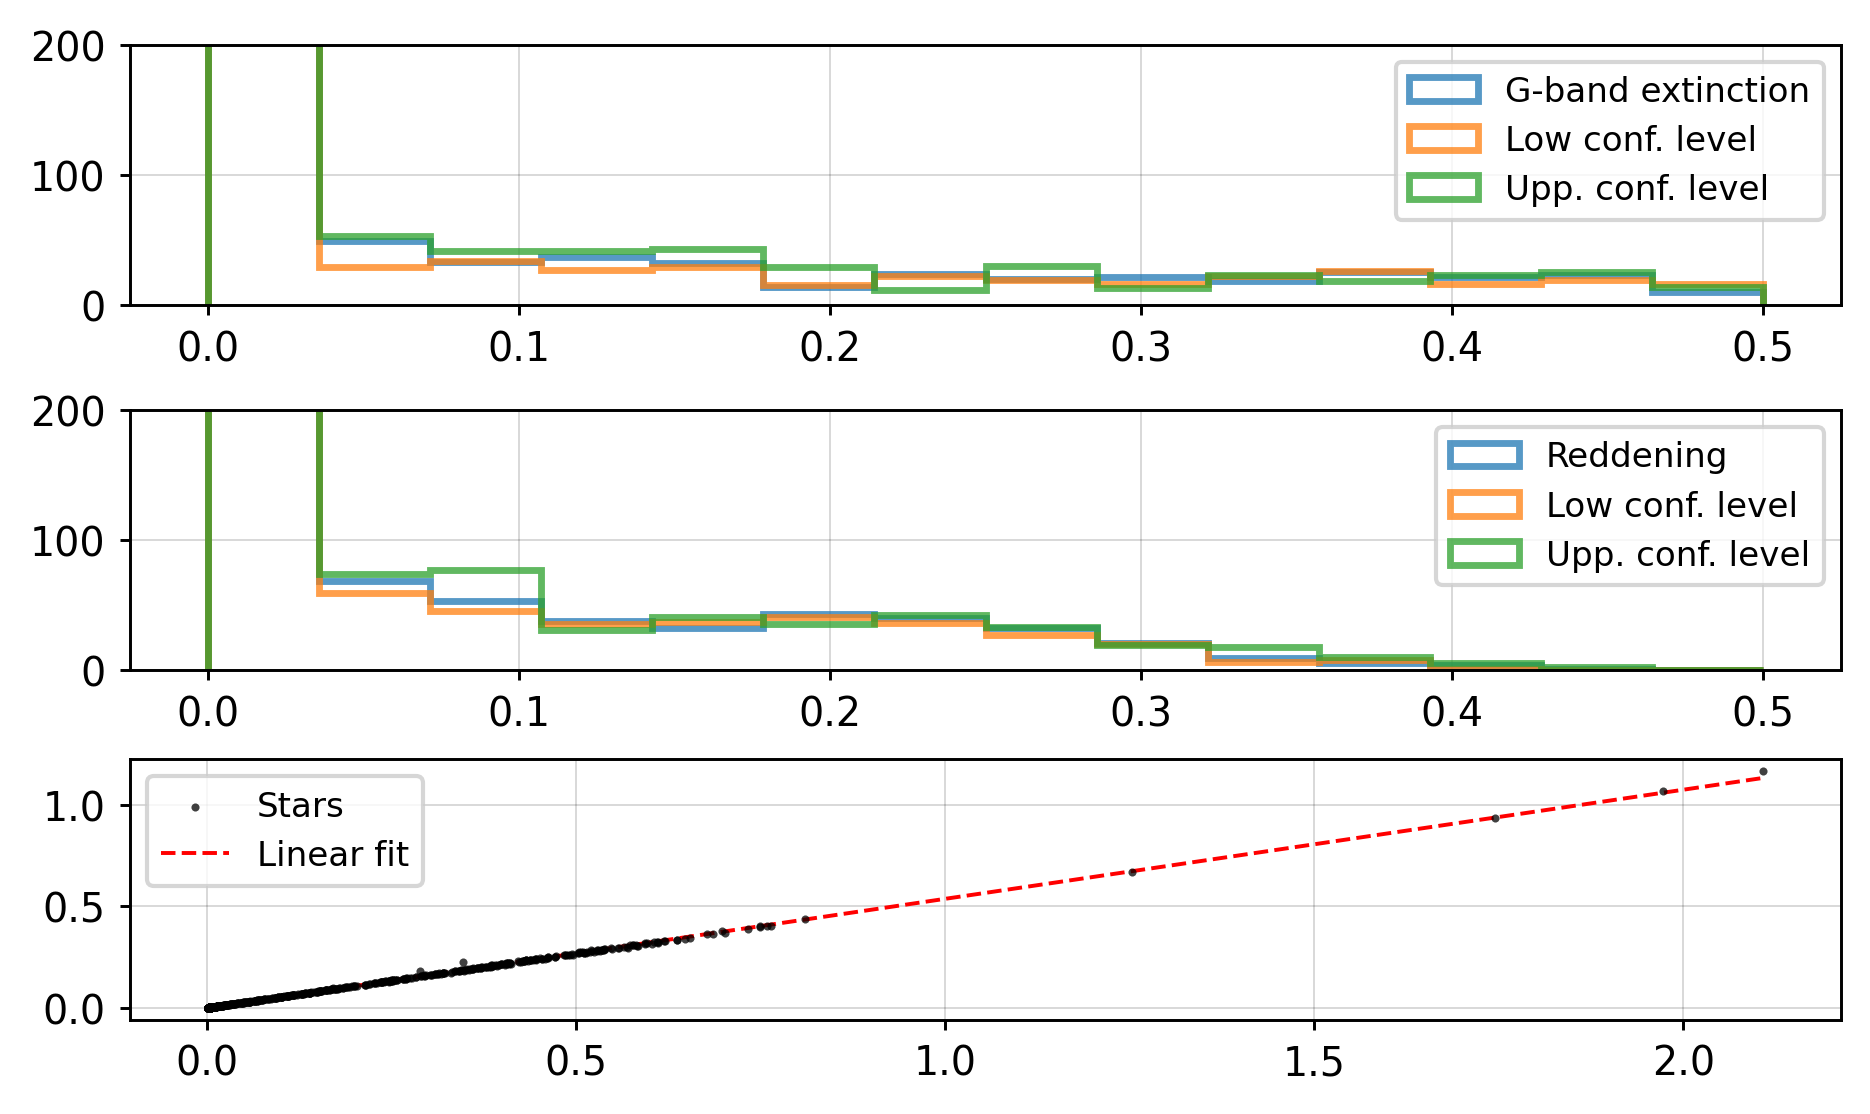

In [10]:
size, rat = 1080, 1.7
fig_w, fig_h = size*rat, size
subplots = (3, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

cmap = mpl.colormaps['viridis']
subclusters_list = []

eps_ = [5, 0.75]
for i, cluster_name in enumerate(cluster_names[1:]):
    print(cluster_name)
    cluster = cluster_dic[cluster_name]
    data = cluster['data_filt_2']
    x, y = np.array(data['ag_gspphot']), np.array(data['ebpminrp_gspphot'])

    mask = ~np.isnan(x) & ~np.isnan(y)
    # Apply the masks to x and y
    x_valid = x[mask]
    y_valid = y[mask]
    slope, intercept = np.polyfit(x_valid, y_valid, 1)
    print(f'Slope: {slope:0.02f}')
    print(f'Intercept: {intercept:0.02f}')
    print(f'Mean Extintion: {np.nanmean(x):0.02e}')
    print(f'Mean Reddening: {np.nanmean(y):0.02e}')
    print(f'p90 Extintion: {np.percentile(x_valid, 90):0.02e} ({0.1*len(x_valid):0.0f} Stars above)')
    print(f'p99 Extintion: {np.percentile(x_valid, 99):0.02e} ({0.01*len(x_valid):0.0f} Stars above)')




    ax = axs[0][i]
    ax_ = axs[1][i]
    ax__ = axs[2][i]

    # make histogram fo the distributino of x
    # define the range and number of bins
    bin_range = (0, 0.5) if i==0 else (0, 0.05)
    num_bins = 14 if i==0 else 100
    # create the histogram
    # hist, bins = np.histogram(x, bins=num_bins, range=bin_range)
    # hist, bins = np.histogram(x, bins=num_bins, range=bin_range)

    # plot the histogram
    ax.hist(x, bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step',
            linewidth=0.35*fs, label='G-band extinction')
    ax.hist(data['ag_gspphot_lower'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Low conf. level')
    ax.hist(data['ag_gspphot_upper'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Upp. conf. level')

    ax_.hist(y, bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step',
             linewidth=0.35*fs, label='Reddening')
    ax_.hist(data['ebpminrp_gspphot_lower'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Low conf. level')
    ax_.hist(data['ebpminrp_gspphot_upper'], bins=num_bins, range=bin_range, density=False, alpha=0.75, histtype='step', linewidth=0.35*fs, label='Upp. conf. level')

    ax__.scatter(x, y, c='k', s=0.75*fs, zorder=4, 
                linewidths=0.01*fs, edgecolor='k', alpha=0.75,
                label='Stars')
# plot the line with slope intercept
    x1, x2 = np.nanmin(x), np.nanmax(x)
    p1, p2 = [x1, intercept + slope*x1], [x2,  intercept + slope*x2]
    ax__.plot([p1[0], p2[0]], [p1[1], p2[1]], color='r', linewidth=0.2*fs, 
              label='Linear fit', linestyle='--')

    # plot legend
    for xa in [ax, ax_, ax__]:
        xa.legend(scatterpoints=1, frameon=True, 
                labelspacing=0.1*fs, 
                loc='upper right' if xa in [ax, ax_] else 'upper left',
                fontsize=1.75*fs)
        
    ax__.ticklabel_format(style='sci', axis='both', scilimits=(0,0))

# axs[0][0].set_title('Hyades', fontsize=2*fs)
# axs[0][1].set_title('47 Tucanae', fontsize=2*fs)

axs[0][0].set_ylim(0, 200)
axs[1][0].set_ylim(0, 200)
# for i in range(3):
#     axs[i][1].yaxis.tick_right()
#     axs[i][1].yaxis.set_label_position("right")




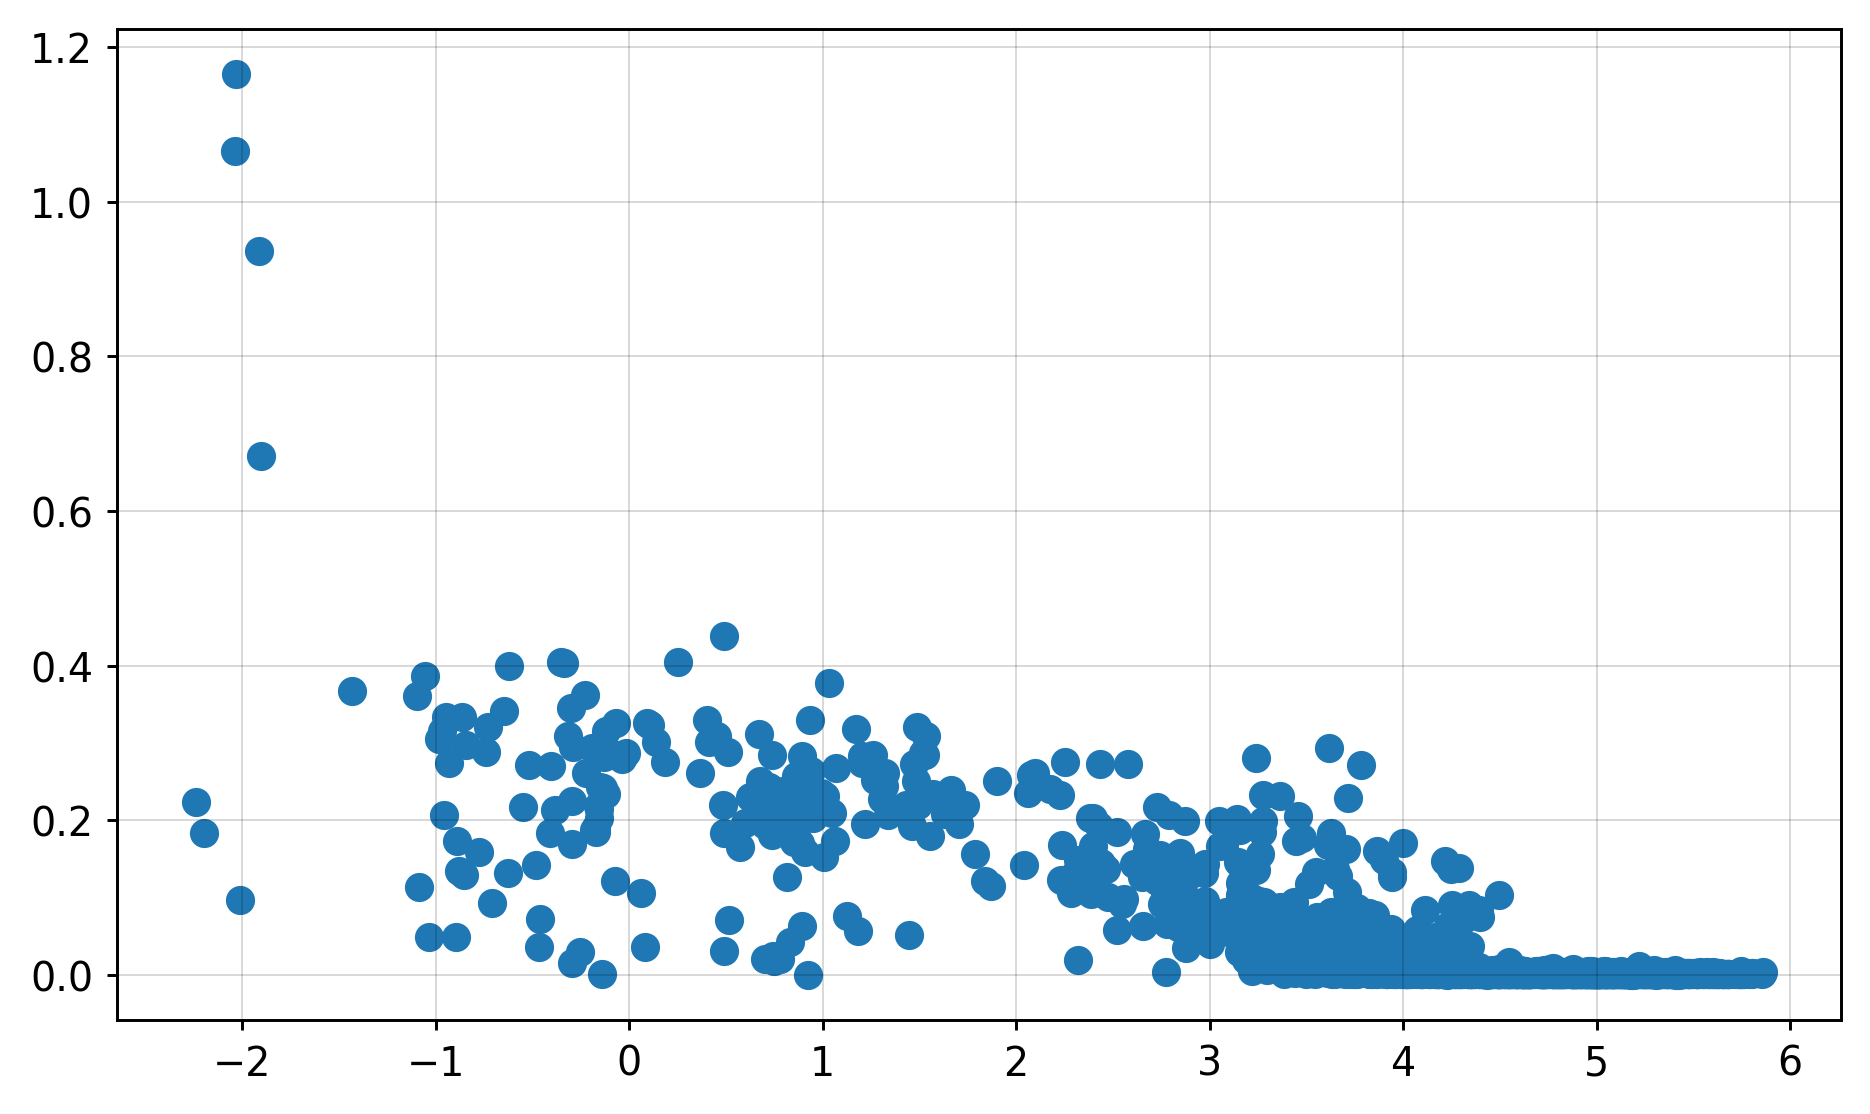

In [11]:
size, rat = 1080, 1.7
fig_w, fig_h = size*rat, size
subplots = (1, 1)
fig, axs, fs, gs = pu.initialize_figure(fig_w=fig_w, fig_h=fig_h, subplots=subplots, 
                                   ratio=None, theme=None, text_size=1.35, wspace=0.1)

cluster = cluster_dic[cluster_name]
data = cluster['data_filt_2']

x, y = np.array(data['g_abs']), np.array(data['ag_gspphot'])
x_, y_ = np.array(data['bp_rp_mag']), np.array(data['ebpminrp_gspphot'])

axs[0][0].scatter(x, y_)
